In [39]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.sparse import coo_matrix 
from qutip import *

%matplotlib inline

**Equation of Motion for the Field**

$$
\begin{aligned}
\dot{\rho}_{nm} =
&- \frac{M_{nm}A}{1 + N_{nm}B/A} \rho_{nm} + \frac{\sqrt{nm}A}{1 + N_{n-1,m-1}B/A} \rho_{n-1,m-1} \\
&- \frac{\kappa}{2}(n+m)\rho_{nm} + \kappa\sqrt{(n+1)(m+1)} \rho_{n+1, m+1}
\end{aligned}
$$

where
$$
\begin{aligned}
A &= \frac{2r_a g^2}{\gamma^2},~ ~ ~B = \frac{4g^2}{\gamma^2} A,\\
M &= \frac{1}{2}(n+n'+2) + (n-n')^2\frac{B}{8A},\\
N &= \frac{1}{2}(n+n'+2) + (n-n')^2\frac{B}{16A}.
\end{aligned}
$$

In particular, for diagonal elements, we have

$$
\begin{aligned}
\dot{p}(n) =
&- \frac{(n+1)A}{1 + (n+1)B/A} p(n) + \frac{nA}{1 + nB/A} p(n-1) \\
&- \kappa np(n) + \kappa(n+1)p(n+1)
\end{aligned}
$$

In [43]:
# functions to calculate parameters

def A(ra, g, gamma):
    return 2 * ra * g**2 / gamma**2

def B(g, gamma, fA):
    return 4 * fA * g**2 / gamma**2

def BdA(g, gamma):
    return 4 * g**2 / gamma**2

def M(n, m, fBdA):
    return 0.5 * (n + m + 2) + (n - m)**2 * fBdA / 8

def N(n, m, fBdA):
    return 0.5 * (n + m + 2) + (n - m)**2 * fBdA / 16

def n_p(fA, fB, kappa):
    return fA * (fA - kappa) / kappa / fB

In [71]:
# parameters

w_c = 2.0 * np.pi
w_a = 2.0 * np.pi
g = 0.05 * 2 * np.pi

gamma = 0.01
kappa = 0.01
ra = 0.4

N_max = 80

fA = A(ra, g, gamma)
fB = B(g, gamma, fA)
fBdA = BdA(g, gamma)
aver_n = n_p(fA, fB, kappa)

In [72]:
fA, fB, kappa

(789.5683520871487, 3117090.9130880777, 0.01)

In [73]:
fB/fA, fBdA

(3947.841760435743, 3947.841760435743)

In [74]:
# average photon number for steady state
aver_n

19.999746697040898

In [75]:
# coefficients of the differential equation

def fnm(n, m, fA, fBdA, kappa):
    return - (M(n, m, fBdA) * fA / (1 + N(n, m, fBdA) * fBdA)) - 0.5 * kappa * (n + m)

def gnm(n, m, fA, fBdA):
    return np.sqrt(n * m) * fA / (1 + N (n - 1, m - 1, fBdA) * fBdA)

def hnm(n, m, kappa):
    return kappa * np.sqrt((n + 1) * (m + 1))

In [76]:
# parameters in the differential equation
ij = range(N_max)
FNM = np.array([fnm(i, j, fA, fBdA, kappa) for i in ij for j in ij]).reshape(N_max, N_max)
GNM = np.array([gnm(i, j, fA, fBdA) for i in ij for j in ij]).reshape(N_max, N_max)
HNM = np.array([hnm(i, j, kappa) for i in ij for j in ij]).reshape(N_max, N_max)

In [77]:
FNM

array([[-0.19994935, -0.40379109, -0.40959543, ..., -0.7849946 ,
        -0.78999467, -0.79499474],
       [-0.40379109, -0.20997467, -0.4129935 , ..., -0.78999439,
        -0.79499446, -0.79999454],
       [-0.40959543, -0.4129935 , -0.21998311, ..., -0.79499416,
        -0.79999425, -0.80499433],
       ..., 
       [-0.7849946 , -0.78999439, -0.79499416, ..., -0.96999935,
        -1.1267277 , -1.16517759],
       [-0.78999467, -0.79499446, -0.79999425, ..., -1.1267277 ,
        -0.97999936, -1.13626262],
       [-0.79499474, -0.79999454, -0.80499433, ..., -1.16517759,
        -1.13626262, -0.98999937]])

In [78]:
FNM.reshape(-1)

array([-0.19994935, -0.40379109, -0.40959543, ..., -1.16517759,
       -1.13626262, -0.98999937])

In [79]:
# differential equation
def rho_nm_dot(rho_nm, t):
    rho = rho_nm.reshape(N_max, N_max)
    rho_new = np.zeros([N_max, N_max])
    
    ij = range(N_max)
    for i in ij:
        for j in ij:
            rho_new[i, j] += FNM[i, j] * rho[i, j]
            if i > 0 and j > 0:
                rho_new[i, j] += GNM[i, j] * rho[i - 1, j - 1]
            if i < N_max - 1 and j < N_max - 1:
                rho_new[i, j] += HNM[i, j] * rho[i + 1, j + 1]
    
    return rho_new.reshape(-1)

In [80]:
t_list = np.linspace(0, 200, 801)
rho_0 = np.zeros(N_max * N_max)
rho_0[0] = 1

In [81]:
rho_0

array([ 1.,  0.,  0., ...,  0.,  0.,  0.])

In [82]:
result = odeint(rho_nm_dot, rho_0, t_list)

In [83]:
len(result)

801

In [84]:
result[100].reshape(N_max, N_max)

array([[  1.19986637e-02,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   5.30563975e-02,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.17330139e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.86758414e-66,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   9.80885578e-68,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   4.91195663e-69]])

In [85]:
Qobj(result[100].reshape(N_max, N_max))

Quantum object: dims = [[80], [80]], shape = [80, 80], type = oper, isherm = True
Qobj data =
[[  1.19986637e-02   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   5.30563975e-02   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.17330139e-01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   1.86758414e-66
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    9.80885578e-68   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   4.91195663e-69]]

In [86]:
# ordinary differential equation for the diagonal terms

def pn_dot(pn, t):
    pn_new = np.zeros(N_max)
    for n in xrange(N_max):
        pn_new[n] += (- (n + 1) * fA / (1 + (n + 1) * fBdA)  - kappa * n) * pn[n]
        if n > 0:
            pn_new[n] += n * fA / (1 + n * fBdA) * pn[n-1]
        if n < N_max - 1:
            pn_new[n] += kappa * (n+1) * pn[n + 1]
    return pn_new

### initial state: fock

In [87]:
t_list = np.linspace(0, 400, 3201)
pn_0 = np.zeros(N_max)
pn_0[0] = 1

In [88]:
result2 = odeint(pn_dot, pn_0, t_list)

In [89]:
result2[100]

array([  9.54186605e-02,   2.24152056e-01,   2.63331702e-01,
         2.06253938e-01,   1.21165249e-01,   5.69446840e-02,
         2.23024850e-02,   7.48705504e-03,   2.19927835e-03,
         5.74247736e-04,   1.34946800e-04,   2.88293257e-05,
         5.64571904e-06,   1.02057359e-06,   1.71312474e-07,
         2.68396818e-08,   3.94227764e-09,   5.45006085e-10,
         7.11618940e-11,   8.80295870e-12,   1.03453855e-12,
         1.15793141e-13,   1.23711790e-14,   1.26418555e-15,
         1.23788644e-16,   1.16343102e-17,   1.05109741e-18,
         9.14080036e-20,   7.66111440e-21,   6.19515812e-22,
         4.83846438e-23,   3.65282318e-24,   2.66795338e-25,
         1.88657950e-26,   1.29226904e-27,   8.57987721e-29,
         5.52443663e-30,   3.45042116e-31,   2.09123789e-32,
         1.23044616e-33,   7.02831089e-35,   3.89762693e-36,
         2.09902877e-37,   1.09766839e-38,   5.57301420e-40,
         2.74693911e-41,   1.31408043e-42,   6.09962139e-44,
         2.74679736e-45,

In [90]:
aver_n = []
for vec in result2:
    n = sum(vec * range(N_max))
    aver_n.append(n)

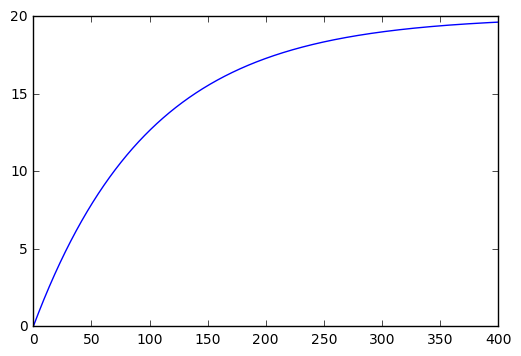

In [91]:
plt.plot(t_list, aver_n)
plt.show()

### initial state: coherent

In [92]:
t_list = np.linspace(0, 400, 3201)
rho_0 = coherent_dm(N_max, 1)
rho_0 = np.real(coo_matrix(rho_0.data).toarray().reshape(-1))

In [ ]:
result3 = odeint(rho_nm_dot, rho_0, t_list)

In [67]:
result3_rho = [Qobj(vec.reshape(N_max, N_max)) for vec in result3]

In [68]:
num_op = num(N_max)
aver_n = [expect(num_op, rho) for rho in result3_rho]

# for vec in result3:
#     rho = vec.reshape(N_max, N_max)
#     rho = Qobj(rho)
#     n = expect(num_op, rho)
#     aver_n.append(n)


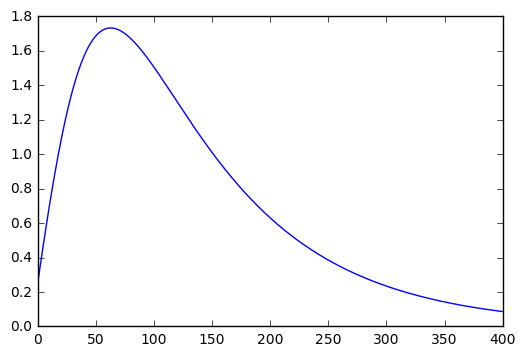

In [69]:
plt.plot(t_list, aver_n)
plt.show()

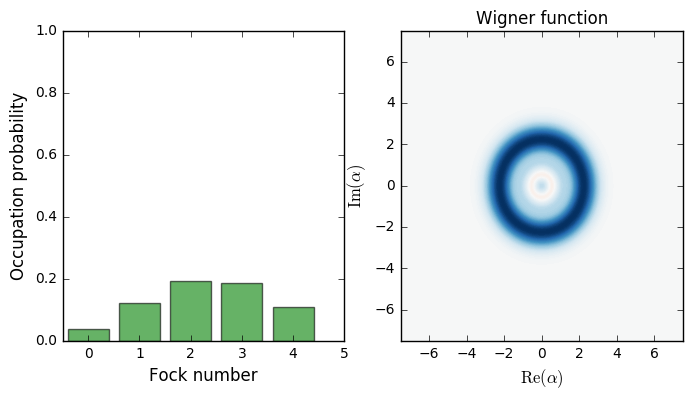

In [70]:
plot_wigner_fock_distribution(result3_rho[801]);